In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

plt.ion()

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

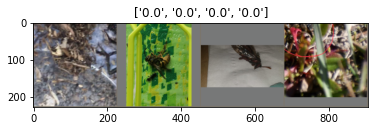

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

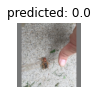

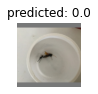

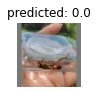

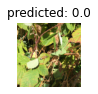

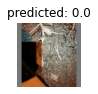

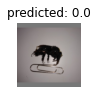

In [17]:
import pickle

# pickle.dump(model_ft, open('model_ft.pkl', 'wb'))
model_ft = pickle.load(open('model_ft.pkl', 'rb'))

visualize_model(model_ft)

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0414 Acc: 0.9937
val Loss: 0.0188 Acc: 0.9985

Epoch 1/24
----------
train Loss: 0.0308 Acc: 0.9952
val Loss: 0.0132 Acc: 0.9985

Epoch 2/24
----------
train Loss: 0.0319 Acc: 0.9952
val Loss: 0.0139 Acc: 0.9985

Epoch 3/24
----------
train Loss: 0.0309 Acc: 0.9952
val Loss: 0.0136 Acc: 0.9985

Epoch 4/24
----------
train Loss: 0.0268 Acc: 0.9952
val Loss: 0.0140 Acc: 0.9985

Epoch 5/24
----------
train Loss: 0.0240 Acc: 0.9952
val Loss: 0.0146 Acc: 0.9985

Epoch 6/24
----------
train Loss: 0.0249 Acc: 0.9952
val Loss: 0.0148 Acc: 0.9985

Epoch 7/24
----------
train Loss: 0.0218 Acc: 0.9952
val Loss: 0.0143 Acc: 0.9985

Epoch 8/24
----------
train Loss: 0.0220 Acc: 0.9952
val Loss: 0.0145 Acc: 0.9985

Epoch 9/24
----------
train Loss: 0.0237 Acc: 0.9952
val Loss: 0.0139 Acc: 0.9985

Epoch 10/24
----------
train Loss: 0.0210 Acc: 0.9952
val Loss: 0.0126 Acc: 0.9985

Epoch 11/24
----------
train Loss: 0.0233 Acc: 0.9952
val Loss: 0.0136 Acc: 0.9985

Ep

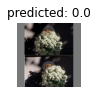

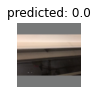

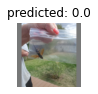

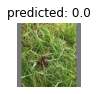

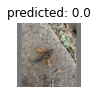

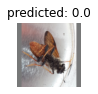

In [20]:
visualize_model(model_conv)

plt.show()

In [21]:
import torch
from PIL import Image
from pathlib import Path

def classify_image(model, path_):
    image = Image.open(Path(path_))
    input = data_transforms['val'](image)
    input = input.view(1, 3, 224, 224)
    input = input.to(device)

    output_ = model(input)

    prediction = int(torch.max(output_.cpu().data, 1)[1].numpy())
    return prediction

In [22]:
# Re-label all data by model_conv

import numpy as np
import pandas as pd

from preprocess import load_and_process

import logging
import sys

# logging.basicConfig(level=logging.INFO, stream=sys.stderr)
data, image_id = load_and_process()

def predict_with_model(model):
    y_pred_cnn_ = pd.DataFrame(-np.ones((data.shape[0], 1)), index=data.index, columns=['cnn_score'])

    input_dir = Path('data_cp')

    for files in os.listdir(input_dir):
        file_name = os.path.splitext(files)[0]

        # If the image is clipped from a video, the file_name does not match what records in image_id
        if file_name not in image_id['FileName'].values:
            file_name = file_name.split('_clip_')[0]
            file_name = file_name.split('_copy_')[0]
        global_id_list = image_id[image_id['FileName'] == file_name].index
        if global_id_list is None or len(global_id_list) == 0:
            logging.debug(file_name)
            continue
        global_id = global_id_list[0]

        # print(max(classify_image(input_dir/files), y_pred_cnn_.loc[global_id, 'cnn_score']))
        # y_pred_cnn_.loc[global_id, 'cnn_score'] = 500
        # break
        y_pred_cnn_.loc[global_id, 'cnn_score'] = max(classify_image(model, input_dir/files), y_pred_cnn_.loc[global_id, 'cnn_score'])

    y_pred_cnn_ = np.maximum(y_pred_cnn_, 0)
    return y_pred_cnn_

y_pred_cnn = predict_with_model(model_conv)

/home/aris/anaconda3/envs/torch/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [2]:
# Pickle and Load trained models

import pickle

pickle.dump(model_conv, open('model_conv.pkl', 'wb'))
# model_conv = pickle.load(open('model_conv.pkl', 'rb'))
y_pred_cnn.to_csv('y_pred_cnn.csv')

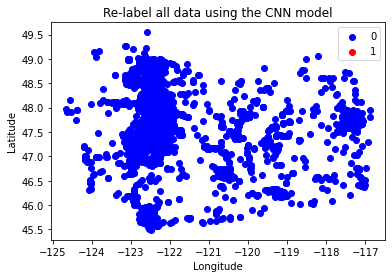

In [23]:
import matplotlib.pyplot as plt

c_dict = {
    0: "blue",
    1: "red"
}

fig, ax = plt.subplots()

for label in c_dict.keys():
    plt_data = y_pred_cnn['cnn_score']==label
    ax.scatter(data.loc[plt_data, 'Longitude'], data.loc[plt_data, 'Latitude'], c=c_dict[label], label=label)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Re-label all data using the CNN model")
ax.legend()
plt.savefig('fig/re-labeled_cnn.png')
plt.show()

In [24]:
# Train a model with oversampling

# ***********************************************************
# ***** CAUTION *********************************************
# Need to exec `oversampling.sh` for over sampling the images
# ***********************************************************

data_dir = 'data_oversampling'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [25]:
# Make the model
model_conv_on_sampling = torchvision.models.resnet18(pretrained=True)
for param in model_conv_on_sampling.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_on_sampling.fc.in_features
model_conv_on_sampling.fc = nn.Linear(num_ftrs, 2)

model_conv_on_sampling = model_conv_on_sampling.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv_on_sampling.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
# Train the model
model_conv_on_sampling = train_model(model_conv_on_sampling, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2078 Acc: 0.9374
val Loss: 0.0954 Acc: 0.9567

Epoch 1/24
----------
train Loss: 0.1549 Acc: 0.9423
val Loss: 0.0739 Acc: 0.9707

Epoch 2/24
----------
train Loss: 0.1240 Acc: 0.9560
val Loss: 0.0647 Acc: 0.9721

Epoch 3/24
----------
train Loss: 0.1167 Acc: 0.9626
val Loss: 0.0569 Acc: 0.9846

Epoch 4/24
----------
train Loss: 0.1205 Acc: 0.9570
val Loss: 0.0716 Acc: 0.9749

Epoch 5/24
----------
train Loss: 0.1257 Acc: 0.9581
val Loss: 0.0689 Acc: 0.9777

Epoch 6/24
----------
train Loss: 0.1220 Acc: 0.9591
val Loss: 0.0863 Acc: 0.9637

Epoch 7/24
----------
train Loss: 0.1015 Acc: 0.9640
val Loss: 0.0536 Acc: 0.9860

Epoch 8/24
----------
train Loss: 0.0937 Acc: 0.9692
val Loss: 0.0542 Acc: 0.9874

Epoch 9/24
----------
train Loss: 0.0995 Acc: 0.9664
val Loss: 0.0626 Acc: 0.9804

Epoch 10/24
----------
train Loss: 0.0946 Acc: 0.9650
val Loss: 0.0749 Acc: 0.9791

Epoch 11/24
----------
train Loss: 0.0942 Acc: 0.9678
val Loss: 0.0562 Acc: 0.9832

Ep

In [28]:
# Re-label all data withe model_conv_on_sampling

y_pred_cnn_sampling = predict_with_model(model_conv_on_sampling)
pickle.dump(model_conv_on_sampling, open('model_conv_on_sampling.pkl', 'wb'))
y_pred_cnn_sampling.to_csv('y_pred_cnn_sampling.csv')

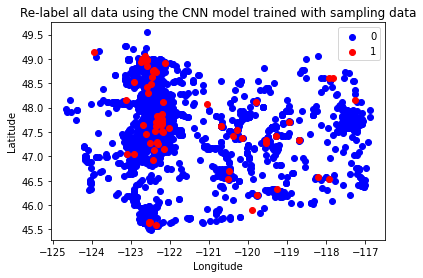

In [30]:
fig, ax = plt.subplots()

for label in c_dict.keys():
    plt_data = y_pred_cnn_sampling['cnn_score']==label
    ax.scatter(data.loc[plt_data, 'Longitude'], data.loc[plt_data, 'Latitude'], c=c_dict[label], label=label)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Re-label all data using the CNN model trained with sampling data")
ax.legend()
plt.savefig('fig/re-labeled_cnn_sampling.png')
plt.show()